# Assignment: Singular Value Decomposition

---


<b><div style="text-align: right">[TOTAL POINTS: 20]</div></b>

Welcome to the Final Assignment of the Module.
Here we test your understanding of the Singular Value Decomposition (SVD) by demonstrating a use case for doing cool stuffs with SVD.

Our main task in this assignment is to use SVD to calculate surface normal for individual points in a point clouds. These surface normals can be useful in diferent applications involving 3D shapes, including but not limmited to robotics, graphics, computer vision etc.


*Note: Surface normal refers to a vector that is perpendicular to a plane that describes any surface.*


## Dataset Description
**Source:**: The dataset used in this assignment is a famous 3D model named: Stanford Bunny model whose details can be found [here](http://graphics.stanford.edu/data/3Dscanrep/).

Number of Instances: **40256**

Number of Attributes: **3**

---
Real-life data relating to 3D objects are sometimes represented in form of **point clouds**. 

Pointcloud refers to a set of data points in a space. We restrict ourselves to the 3 dimensional Cartesian Space, which by now you might have realized is the most natural way to think about objects in real life. 

So when a real-life 3d object is represented as a point cloud, we expect the object to be represented by many points which are part of the object's surface and the appearence of the point cloud in bulk is such that it builds perception of vision of that particular object to a human observer.

Here is a small animation that will help you visualize how the 3D model actually looks:
<figure>
  <center>
    <img src='https://storage.googleapis.com/codehub-data/5-A-2-7-bunny.gif'/>
  </center>
</figure>
Notice that the yellowish looking points are dense enough and also positioned such that they give the visual perception of bunny, when infact they are just points in 3D plane with (x,y,z) coordinates. We shall see the data shortly. One thing to note is that it is completely different from how a normal image (2d image) is represented.

The attributes of the data are as follows:

1.   **x:** x co-ordinate of a point
1.   **y:** y co-ordinate of a point
1.   **z:** z co-ordinate of a point

The target is to compute **surface normals** for different points in point-cloud.

Lets get started by importing necessary modules: The usual suspects: Numpy, and Matplotlib. We also import cKDTree from scipy. This will be useful in later part of assignment but we will not go into much details as the details are irrelevant to the course. Just keep in mind that we will use it later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

Now, let us have a quick look at the data:

In [5]:
!wget -qO bunny.xyz 'https://storage.googleapis.com/codehub-data/5-A-2-7-bunny.xyz'
bunny_points = np.genfromtxt('bunny.xyz')
bunny_points

array([[-0.06325 ,  0.035979,  0.042087],
       [-0.06275 ,  0.036034,  0.042595],
       [-0.0645  ,  0.03651 ,  0.040436],
       ...,
       [-0.01575 ,  0.187201, -0.022021],
       [-0.01525 ,  0.187218, -0.023778],
       [-0.018   ,  0.18794 , -0.019725]])

In [3]:
bunny_points.shape

(40256, 3)

The shape of (40256, 3), as you might have guessed it refers to the 40256 points each represented by a row and the 3 columns representing the x, y and z values.

Now, in many applications we will be interested in projecting the object in 2D instead of using 3D. Let us try to project the image into 2D and visualize it.

For projecting in 2D we try a trivial yet popular method, called the orthographic projection. We want to project the image in the x-y plane so, we simply get rid of the z plane no matter what the value of z. 

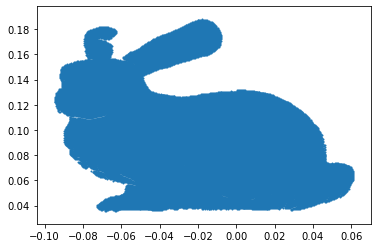

In [56]:
# Code HERE
# find orthographic projection by getting rid of z axis
# 1 line
bunny_projected = bunny_points[:, 0:2]
# Code Ends

# Visualize the orthgraphic projection using scatter plot
plt.scatter(bunny_projected[:,0], bunny_projected[:,1], s=1)

You may have immediately noticed that when this projection is made, a lot of information (especially the information relating to z values) are lost. The projected image does not seem representative of the original image.

This loss of image seems mostly prominent towards the leg (try finding the hind left leg of the bunny in the projected image) and also somehow towards the ear (the grooves of ear visible in the 3D are hidden from 2D.

Also notice that, if we extract edges from this projected bunny (It is common that we look to represent an object by only its edges), the information lost will be lost totally and the edges will be completely different from the original 3D image.

For correctly extracting edges in 2D projection, we might want to do some smart operations in the 3D cloud before we do the projection. This way we will be able to capture the nuances of the object in a more appropriate way. This is where surface normals come handy.

Our next task is to compute surface normals for different points in point-cloud. This surface normals will be later used to filter points from the 3d point cloud before projection, so as to preserve some properties of point-cloud. 

We compute surface normal by following algorithm:

For each point:
1. Find the k nearest neighbors (we use 5)
2. Compute centroid of all the neighbor points
3. Calculate vectors that represent the vectors from centroid to each neighboring points
4. Using SVD, determine the three singular vectors in cartesian coordinates (xyz). The right singular vector with smallest associated singular value is the surface normal.

The first step of algorithm deals with finding nearest neighbor which has already been implemented for you here.

In [89]:
def find_k_neighbors(point_cloud, query_point, k=5):
    """
    Function takes pointcloud and querypoint and number of nearest neighbor to 
    search for.

    Inputs:
        point_cloud: numpy array containing entire pointcloud to search from
        query_point: single point whose neares neighbor is to be calculated
        k: number of nearest neighbors to be calculated, default=5

    Outputs:
        k nearest neighbors of the query_point
    """
    
    tree = cKDTree(point_cloud)
    _, indices = tree.query(query_point, k=k)
    return indices

### Exercise 1: Compute centroid
<b><div style="text-align:right">[POINTS: 5]</div></b>
Calculate the centroid of the neighouring points obtained from above function.

**Task:** 
- Complete the function `compute_centroid` that takes in a $(k, 3)$ shaped numpy array and returns the centroid of given set of points.

**Note:** Centroid of group of vectors will be equal to the mean of their individual components.


In [84]:
def compute_centroid(k_points):
    centroid = None
    # YOUR CODE HERE
    centroid = np.mean(k_points,axis=0)
    return centroid
points__ = np.arange(15).reshape(-1,3)
centroid__ = compute_centroid(points__)
print(centroid__)

[6. 7. 8.]


In [85]:
points__ = np.arange(15).reshape(-1,3)
centroid__ = compute_centroid(points__)


### Exercise 2: Compute vectors
<b><div style="text-align:right">[POINTS: 5]</div></b>
Calculate vectors that represent vectors from centroid to each neighboring points.

**Task:** 
- Calculate vector between two points

*Hint:* Vector from point $\mathbf{x_1}$ to point $\mathbf{x_2}$ will be $\mathbf{x_2 - x_1}$

In [88]:
def compute_vectors(k_points):
    centroid = compute_centroid(k_points)
    # YOUR CODE HERE
    k_vectors = k_points - centroid
    return k_vectors
vectors__ = compute_vectors(points__)
print(vectors__)

[[-6. -6. -6.]
 [-3. -3. -3.]
 [ 0.  0.  0.]
 [ 3.  3.  3.]
 [ 6.  6.  6.]]


In [87]:
vectors__ = compute_vectors(points__)


### Exercise 3: Obtain surface normal of point cloud
<b><div style="text-align:right">[POINTS: 10]</div></b>
Using SVD, determine the three singular vectors in cartesian coordinates (xyz). The right singular vector with smallest associated singular value is the surface normal.

**Task:** 
- Complete function that takes group of vectors in form of matrix, computes SVD, and returns the surface normal, i.e. the right singular vector with smallest singular value which is normally the last row of right singular matrix.

In [76]:
def compute_normal(matrix):
    # Compute SVD: 1 line

    # YOUR CODE HERE
    u,s,vh = np.linalg.svd(matrix)
    surface_normal = vh[2]
    return surface_normal 

In [77]:
normal__ = compute_normal(vectors__)


Now that we have completed all the individual steps, lets combine the algorithm in a single function to compute surface normal.

In [78]:
def get_normals(point_cloud):
    normals = np.zeros_like(point_cloud, dtype='float64')

    neighbor_indices = find_k_neighbors(point_cloud, point_cloud)

    for i, point in enumerate(point_cloud):
        neighbors_ = neighbor_indices[i]
        k_nearest_points = point_cloud[neighbors_]
        k_vectors = compute_vectors(k_nearest_points)
        normal = compute_normal(k_vectors)
        normals[i] = normal

    return normals

Great...
Now lets compute normals for the bunny.

This might take some time..... Be patient, Sit back and relax :)

In [79]:
bunny_normals = get_normals(bunny_points)
bunny_normals.shape

ValueError: operands could not be broadcast together with shapes (5,3) (5,) 

Now that we have the normals, we fliter the points to get the edges.
For this particular task we, filter all the points whose z value for normal has an absolute value less than 0.6: i.e. we filter out points whose z value of normal are either > 0.6 or < 0.6

In [80]:
bunny_normals

array([[ 0.70194603,  0.47990273, -0.52627477],
       [ 0.55483717,  0.5059102 , -0.6604624 ],
       [-0.81507987, -0.21189767,  0.53920699],
       ...,
       [-0.87089258, -0.30214256, -0.38762867],
       [-0.90397695, -0.21108247, -0.37184655],
       [ 0.62097181,  0.66403503,  0.41647509]])

In [81]:
def filter_points(point_cloud, surface_normal):
    condition = np.where(
        np.abs(surface_normal[:, 2]) <= 0.6
    )
    points_filtered = point_cloud[condition]
    return points_filtered

Now lets use this filter to see the outcome

In [82]:
filtered_bunny = filter_points(bunny_points, bunny_normals)
filtered_bunny.shape

(9191, 3)

Now lets plot this bunny.

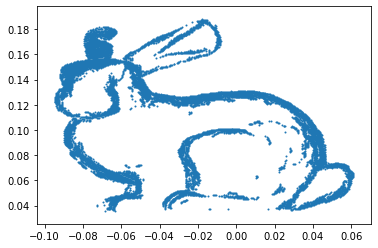

In [83]:
plt.scatter(filtered_bunny[:,0], filtered_bunny[:,1], s=1)

In [41]:
# delete the model file
!rm bunny.xyz

rm: cannot remove 'bunny.xyz': No such file or directory
